In [1]:
import os
# os.environ["CONDA_PREFIX"] = "/opt/conda"
%pip install -U -q uv

Note: you may need to restart the kernel to use updated packages.


In [2]:
!uv pip install small-text torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex kaleido

Audited 7 packages in 74ms


# Imports


In [47]:
import random
import warnings
from pathlib import Path
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import torch
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from sklearnex import patch_sklearn
from torch import nn
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)
from torchsummary import summary
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from skorch import NeuralNetClassifier
if not os.path.exists("reports_FashionMNIST"):
    os.mkdir("reports_FashionMNIST")
patch_sklearn()
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

torch 2.1.0+cu121
torchvision 0.16.0+cu121
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# FashionMNIST


In [4]:
FashionMNIST_train_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)


FashionMNIST_test_data = datasets.FashionMNIST(
    root="data_FashionMNIST",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)


x_train, y_train = FashionMNIST_train_data.data, np.array(
    FashionMNIST_train_data.targets
)


x_test, y_test = FashionMNIST_test_data.data, np.array(FashionMNIST_test_data.targets)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([60000, 28, 28]), (60000,), torch.Size([10000, 28, 28]), (10000,))

In [7]:
FashionMNIST_class_names = FashionMNIST_train_data.classes
print(FashionMNIST_class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
num_classes = len(FashionMNIST_class_names)
num_classes

10

In [9]:
class_to_idx_cif = FashionMNIST_train_data.class_to_idx
print(class_to_idx_cif)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [10]:
# # Show more images
# plt.figure(figsize=(9, 9))
# rows, cols = 4, 4

# for i in range(1, rows * cols + 1):
#     random_index = torch.randint(1, len(FashionMNIST_train_data), size=[1]).item()
#     plt.subplot(rows, cols, i)
#     image, label = FashionMNIST_train_data[random_index]
#     image = image.permute(1, 2, 0).numpy()
#     plt.imshow(image, cmap="gray")
#     plt.title(FashionMNIST_class_names[label])
#     plt.axis(False)

# plt.savefig("reports_FashionMNIST/FashionMNIST_imgs_labeled.png")
# plt.show()

# Unlabeling The Dataset


In [11]:
# Define the percentage of data without labels
percentage_without_labels = 0.8

# Calculate the number of samples without labels
num_samples_without_labels = int(
    len(FashionMNIST_train_data) * percentage_without_labels
)
num_samples_with_labels = len(FashionMNIST_train_data) - num_samples_without_labels

# Create indices for data with labels and without labels
indices_without_labels = np.random.choice(
    range(len(FashionMNIST_train_data)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(FashionMNIST_train_data)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [12]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

(torch.Size([12000, 28, 28]), (12000,), torch.Size([48000, 28, 28]), (48000,))

In [13]:
x_initial.unsqueeze(1).repeat(1, 3, 1, 1).shape

torch.Size([12000, 3, 28, 28])

In [14]:
len(FashionMNIST_train_data)

60000

In [15]:
FashionMNIST_train_data[1][1]

0

# Creating the DataLoaders


In [16]:
def numpy_to_dataloader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(x, dtype=torch.float32).unsqueeze(1).repeat(1, 3, 1, 1),
        torch.tensor(y),
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
BATCH_SIZE_CIF = 32

FashionMNIST_train_data_loader = numpy_to_dataloader(
    x_initial, y_initial, BATCH_SIZE_CIF
)
FashionMNIST_test_data_loader = numpy_to_dataloader(x_test, y_test, BATCH_SIZE_CIF)

In [18]:
FashionMNIST_train_data_loader, FashionMNIST_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f7aac4dc990>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7aac4dca90>)

In [19]:
print(
    f"Length of Training Data loader: {len(FashionMNIST_train_data_loader)}, Batches of {FashionMNIST_train_data_loader.batch_size}"
)
print(
    f"Length of Testing Data loader: {len(FashionMNIST_test_data_loader)}, Batches of {FashionMNIST_test_data_loader.batch_size}"
)

Length of Training Data loader: 375, Batches of 32
Length of Testing Data loader: 313, Batches of 32


# Importing and Using ResNet 50 Architecture


In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [21]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
next(model.parameters()).device

device(type='cpu')

In [22]:
f = nn.Flatten(start_dim=0)  # The default start dim is 1
x = f(torch.randn(10, 7, 7))
x.size()

torch.Size([490])

In [23]:
rand_image_tensor = torch.randn(size=(32, 3, 28, 28))

In [24]:
rand_image_tensor.device

device(type='cpu')

In [25]:
model(rand_image_tensor)

tensor([[ 2.7694e-01,  6.3394e-01, -5.2608e-01, -4.7459e-01, -6.6694e-01,
         -4.4607e-01, -1.1947e-01,  3.3107e-02,  5.8559e-01,  6.0652e-01],
        [ 1.1028e+00,  3.9371e-01, -9.5593e-01,  2.6244e-01, -5.0733e-01,
         -9.1081e-02,  2.9928e-01, -2.9972e-01,  8.1692e-01,  2.0643e-01],
        [ 1.3772e+00,  1.3237e+00, -7.3211e-02,  6.2139e-02, -6.9209e-01,
          4.1054e-01,  2.7685e-01, -2.2058e-01,  8.7156e-02,  1.6374e+00],
        [ 5.7601e-01,  5.0916e-01,  7.8902e-02, -4.8162e-01, -1.1197e-01,
         -5.5792e-01,  7.9284e-01, -4.7441e-01,  8.6716e-02,  5.5689e-01],
        [ 3.8035e-01, -1.1900e-02,  2.3337e-01,  6.0913e-01, -2.6837e-01,
         -2.0432e-01, -1.4684e-02,  4.3649e-01,  1.9756e-01,  1.0377e+00],
        [-1.3170e-02,  1.7446e-01, -6.9537e-01,  2.5247e-01, -4.5342e-01,
         -3.7169e-01, -1.8979e-02, -4.4935e-02, -1.9891e-02,  2.1339e-01],
        [ 4.4491e-01, -1.6786e-01, -3.4535e-01,  1.1977e-01,  1.2069e-01,
         -4.8801e-01, -1.6344e-0

In [26]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

# Printing the Architecture and Number of Trianing Parameters in each Layer


In [27]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

In [28]:
# Picking a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [29]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")

In [30]:
start = timer()
end = timer()
display_train_time(start, end, device="cpu")

Train time on device cpu: 0.000 seconds


In [31]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):
    training_loss = []
    training_acc = []
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        # Put the data on the target device
        x, y = x.to(device), y.to(device)
        # Forward Pass
        y_pred = model(x)
        # Loss
        loss = loss_fn(y_pred, y)
        training_loss.append(loss)
        training_acc.append(
            multiclass_accuracy(y_pred.argmax(dim=1), y, num_classes=10)
        )
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss Backward
        loss.backward()
        # optimizer step step step
        optimizer.step()
    # After looping over batches, divide the training loss over the number of batches to get the average loss per batch
    # train.data_loader (returns the number of batches)
    training_loss = torch.tensor(training_loss).mean()
    # Calculate the average training accuracy
    training_acc = torch.tensor(training_acc).mean()
    print(f"Training -> Loss: {training_loss:.3f} | Accuracy: {training_acc:.3f}")
    return training_acc, training_loss

In [32]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    testing_acc = []
    testing_loss = []
    testing_f1 = []
    testing_precision = []
    testing_recall = []
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_test_pred = model(x)
            # Loss
            testing_loss.append(loss_fn(y_test_pred, y))
            # Accuracy
            testing_acc.append(
                multiclass_accuracy(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            # F1 Score
            testing_f1.append(
                multiclass_f1_score(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            # Precision
            testing_precision.append(
                multiclass_precision(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
            # Recall
            testing_recall.append(
                multiclass_recall(y_test_pred.argmax(dim=1), y, num_classes=10)
            )
        testing_loss = torch.tensor(testing_loss).mean()
        testing_acc = torch.tensor(testing_acc).mean()
        testing_f1 = torch.tensor(testing_f1).mean()
        testing_precision = torch.tensor(testing_precision).mean()
        testing_recall = torch.tensor(testing_recall).mean()
    print(
        f"Testing -> Loss: {testing_loss:.3f} | Accuracy: {testing_acc:.3f} | F1 Score: {testing_f1:.3f} | Precision: {testing_precision:.3f} | Recall: {testing_recall:.3f}"
    )
    return testing_acc, testing_loss, testing_f1, testing_precision, testing_recall

# Base Model Training


In [33]:
# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start = timer()
# Set the number of epochs
epochs = 5
acc_TRAIN = []
acc_TEST = []
loss_TRAIN = []
loss_TEST = []
precision_result = []
recall_result = []
f1_result = []
# Training
for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    ACC_TRAIN = 0
    LOSS_TRAIN = 0
    ACC_TEST = 0
    LOSS_TEST = 0
    F1 = 0
    PRECISION = 0
    RECALL = 0
    # Training
    ACC_TRAIN, LOSS_TRAIN = train_step(
        model, FashionMNIST_train_data_loader, loss_fn, optimizer, device
    )
    # Testing
    ACC_TEST, LOSS_TEST, F1, PRECISION, RECALL = test_step(
        model, FashionMNIST_test_data_loader, loss_fn, device
    )
    # List
    acc_TRAIN.append(ACC_TRAIN.detach().cpu().numpy())
    acc_TEST.append(ACC_TEST.detach().cpu().numpy())
    loss_TRAIN.append(LOSS_TRAIN.detach().cpu().numpy())
    loss_TEST.append(LOSS_TEST.detach().cpu().numpy())
    precision_result.append(PRECISION.detach().cpu().numpy())
    recall_result.append(RECALL.detach().cpu().numpy())
    f1_result.append(F1.detach().cpu().numpy())

# Compute the time of the training
print("\nTraining is finished!\n")
train_end = timer()
display_train_time(train_start, train_end, device=next(model.parameters()).device)

  0%|          | 0/5 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training -> Loss: 2.011 | Accuracy: 0.421%
Testing -> Loss: 0.798 | Accuracy: 0.713 | F1 Score: 0.713 | Precision: 0.713 | Recall: 0.713

epoch: 2
--------------------------------------
Training -> Loss: 0.689 | Accuracy: 0.758%
Testing -> Loss: 0.838 | Accuracy: 0.733 | F1 Score: 0.733 | Precision: 0.733 | Recall: 0.733

epoch: 3
--------------------------------------
Training -> Loss: 0.554 | Accuracy: 0.798%
Testing -> Loss: 0.507 | Accuracy: 0.820 | F1 Score: 0.820 | Precision: 0.820 | Recall: 0.820

epoch: 4
--------------------------------------
Training -> Loss: 0.480 | Accuracy: 0.823%
Testing -> Loss: 0.490 | Accuracy: 0.819 | F1 Score: 0.819 | Precision: 0.819 | Recall: 0.819

epoch: 5
--------------------------------------
Training -> Loss: 0.452 | Accuracy: 0.836%
Testing -> Loss: 0.521 | Accuracy: 0.820 | F1 Score: 0.820 | Precision: 0.820 | Recall: 0.820

Training is finished!

Train time on device cuda:0: 84.740 seconds


In [34]:
# Create a figure and axes
fig = go.Figure()
# Add traces
fig.add_trace(
    go.Line(
        x=np.arange(1, epochs + 1), y=acc_TRAIN, mode="lines", name="Train Accuracy"
    )
)
fig.add_trace(
    go.Line(x=np.arange(1, epochs + 1), y=acc_TEST, mode="lines", name="Test Accuracy")
)
fig.add_trace(
    go.Line(x=np.arange(1, epochs + 1), y=loss_TRAIN, mode="lines", name="Train Loss")
)
fig.add_trace(
    go.Line(x=np.arange(1, epochs + 1), y=loss_TEST, mode="lines", name="Test Loss")
)
# fig.add_trace(
#     go.Line(x=np.arange(1, epochs + 1), y=precision_result, mode="lines", name="Precision")
# )
# fig.add_trace(
#     go.Line(x=np.arange(1, epochs + 1), y=recall_result, mode="lines", name="Recall")
# )
fig.add_trace(
    go.Line(x=np.arange(1, epochs + 1), y=f1_result, mode="lines", name="F1 Score")
)

# Set title and labels
fig.update_layout(
    title_text="Train vs Test",
    xaxis_title="Epochs",
    yaxis_title="Accuracy / Loss / F1 Score",
)
# Save the figure
fig.write_image("reports_FashionMNIST/FashionMNIST_accuracy_train_vs_test.png")
# Show the figure
fig.show()

/home/mohamed/anaconda3/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [35]:
torch.manual_seed(42)

In [36]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    model.eval()
    loss = 0
    acc = 0
    f1 = 0
    precision = 0
    recall = 0
    y_pred_list = []
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_pred = model(x)
            # Loss
            loss += loss_fn(y_pred, y)
            y_pred_list.append(y_pred.argmax(dim=1).cpu().numpy())
            acc += multiclass_accuracy(torch.argmax(y_pred, dim=1), y, num_classes=10)
            f1 += multiclass_f1_score(y_pred.argmax(dim=1), y, num_classes=10)
            precision += multiclass_precision(y_pred.argmax(dim=1), y, num_classes=10)
            recall += multiclass_recall(y_pred.argmax(dim=1), y, num_classes=10)
        loss /= len(data_loader)
        acc /= len(data_loader)
        f1 /= len(data_loader)
        precision /= len(data_loader)
        recall /= len(data_loader)
        y_pred_list = np.concatenate(y_pred_list)
    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
    }, y_pred_list

In [37]:
# Testing the model
model_results, y_pred = eval_model(model, FashionMNIST_test_data_loader, loss_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [38]:
model_results

{'Model Name': 'ResNet',
 'Model Loss': 0.5214000344276428,
 'Model Accuracy': tensor(0.8197, device='cuda:0'),
 'F1 Score': tensor(0.8197, device='cuda:0'),
 'Precision': tensor(0.8197, device='cuda:0'),
 'Recall': tensor(0.8197, device='cuda:0')}

In [39]:
y_pred.shape

(10000,)

# Evaluating Model Visually


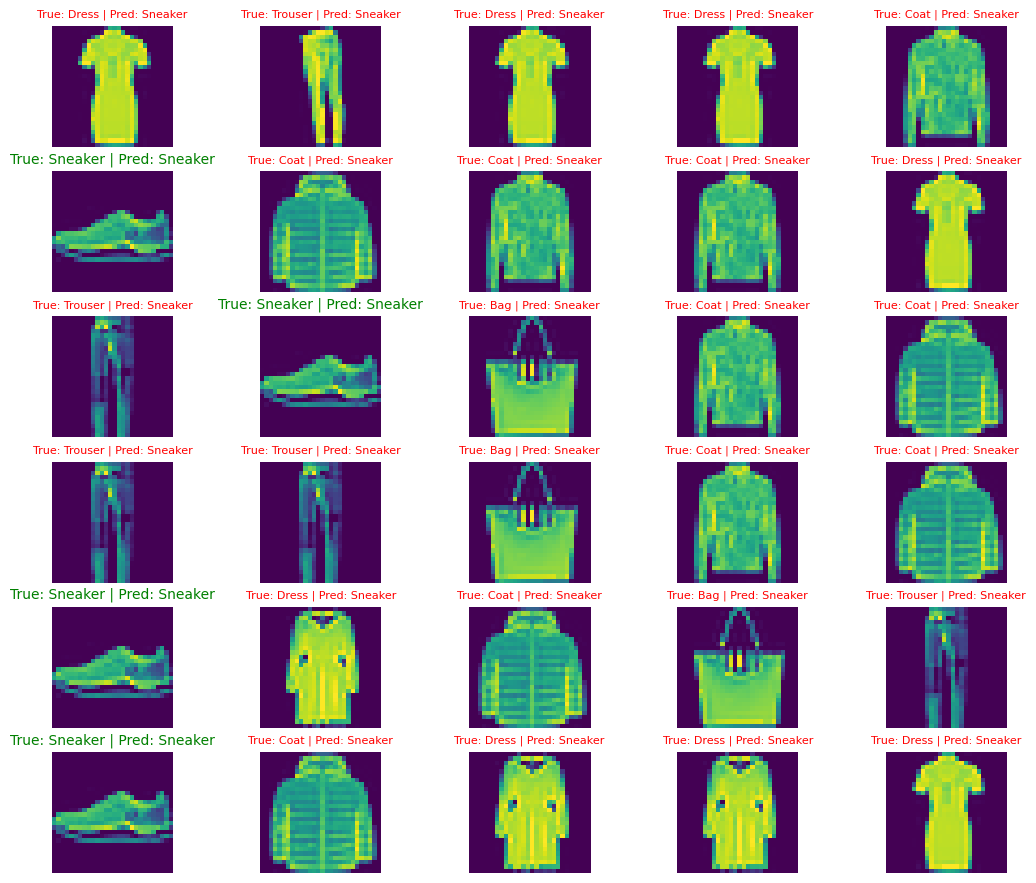

In [41]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(FashionMNIST_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(0).repeat(1, 3, 1, 1).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image)
        if pred_label == label:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="g",
                fontsize=10,
            )
        else:
            plt.title(
                f"True: {FashionMNIST_class_names[label]} | Pred: {FashionMNIST_class_names[pred_label]}",
                c="r",
                fontsize=8,
            )
        plt.axis(False)
plt.savefig("reports_FashionMNIST/preds_base_model_before_al.png")

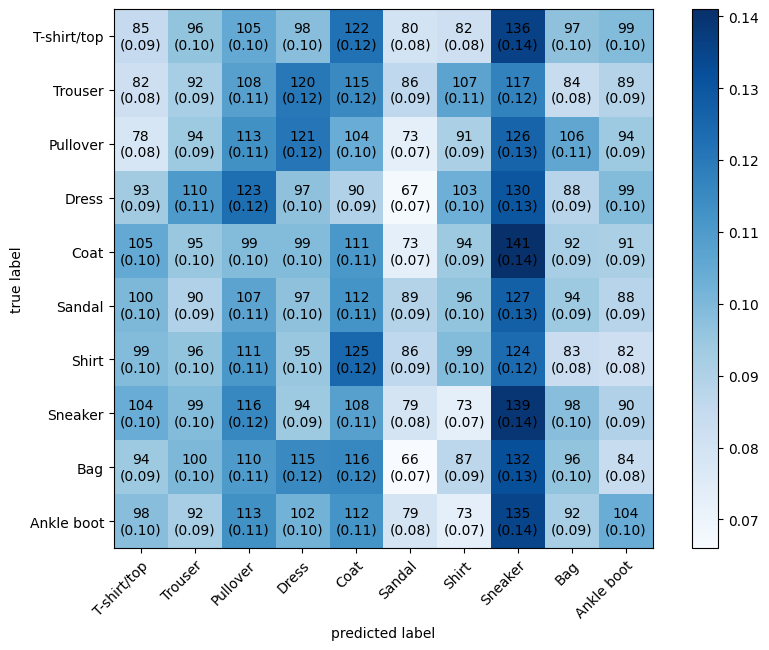

In [42]:
confusion_matrix = multiclass_confusion_matrix(
    torch.tensor(y_pred), torch.tensor(FashionMNIST_test_data.targets), num_classes=10
)
fig, _ = plot_confusion_matrix(
    conf_mat=confusion_matrix.numpy(),
    class_names=FashionMNIST_class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)
plt.savefig("reports_FashionMNIST/conf_mat_base_model_before_al.png")

# Saving the Model


In [43]:
# Create the models path
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)
# Create model save
MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME
# Save the model
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/base_model.pth


# Load the Model


In [44]:
# Create a model instance
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, 10)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
summary(trained_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# Active Learning


In [48]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=1,
    device=device,
)

In [49]:
def active_learning(
    pool_x,
    pool_y,
    initial_x,
    initial_y,
    test_x,
    test_y,
    method,
    model,
    num_classes,
    class_names,
):
    learner = None
    cycles = 10
    acc = []
    precision_result = []
    recall_result = []
    f1_result = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=uncertainty_sampling,
        )
    elif method == "margin_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=margin_sampling,
        )
    elif method == "entropy_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=entropy_sampling,
        )
    elif method == "random_sampling":

        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(
                range(n_samples), size=n_instances, replace=False
            )
            X_query = pool_x[query_idx]
            return query_idx, X_query

        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=random_sampling,
        )
    else:
        print("Invalid Input")
    print(f"Starting Active Learning with {method} method")
    for cycle in range(cycles):
        print(f"\nCycle: {cycle+1}")
        query_idx, _ = learner.query(pool_x, n_instances=1)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)
        model_accuracy = learner.score(
            np.concatenate((initial_x, pool_x), axis=0),
            np.concatenate((initial_y, pool_y), axis=0),
        )
        acc.append(model_accuracy)
        y_pred = learner.predict(test_x)
        # Compute the metrics
        precision_result.append(
            multiclass_precision(
                torch.tensor(y_pred), torch.tensor(test_y), num_classes=10
            )
        )
        recall_result.append(multiclass_recall(torch.tensor(y_pred), torch.tensor(test_y), num_classes=10))
        f1_result.append(multiclass_f1_score(torch.tensor(y_pred), torch.tensor(test_y), num_classes=10))
    confusion_matrix = multiclass_confusion_matrix(
        torch.tensor(y_pred), torch.tensor(test_y), num_classes=10
    )
    fig, _ = plot_confusion_matrix(
        conf_mat=confusion_matrix.compute().numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )
    plt.savefig(f"reports_FashionMNIST/conf_mat_{method}_after_al.png")
    return acc, precision_result, recall_result, f1_result

In [50]:
x_pool = x_pool.unsqueeze(1).repeat(1, 3, 1, 1)
x_initial = x_initial.unsqueeze(1).repeat(1, 3, 1, 1)
x_test = x_test.unsqueeze(1).repeat(1, 3, 1, 1)

x_pool = x_pool.numpy()
x_initial = x_initial.numpy()
x_test = x_test.numpy()

x_pool = x_pool.astype(np.float32)
x_initial = x_initial.astype(np.float32)
x_test = x_test.astype(np.float32)

In [51]:
x_pool.shape, x_initial.shape, x_test.shape

((48000, 3, 28, 28), (12000, 3, 28, 28), (10000, 3, 28, 28))

In [52]:
(
    acc_random_sampling,
    precision_result_random_sampling,
    recall_result_random_sampling,
    f1_result_random_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "random_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.4223  8.3885
      2        0.3571  7.9267
      3        0.3260  7.9218
      4        0.3135  8.0304
      5        0.2878  7.9715
      6        0.2688  7.9902
      7        0.2564  7.9702


Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0324  6.0586
      2        0.0395  6.0327
      3        0.0237  6.0401
      4        0.0293  5.9919
      5        0.0218  6.0048
      6        0.0143  6.0021
      7        0.0121  6.0243
      8        0.0206  6.0057
      9        0.0274  6.0426
     10        0.0415  6.0517
Starting Active Learning with uncertainty_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0306  6.0181
      2        0.0587  6.0399
      3        0.0229  6.0245
      4        0.0084  6.0585
      5        0.0032  5.9801
      6        0.0056  6.0182
      7        0.0052  6.0198
      8        0.0201  6.0126
      9        0.0222  6.0386
     10        0.0266  6.0254
Accuracy after query 1: 0.9034

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0342  6.0070


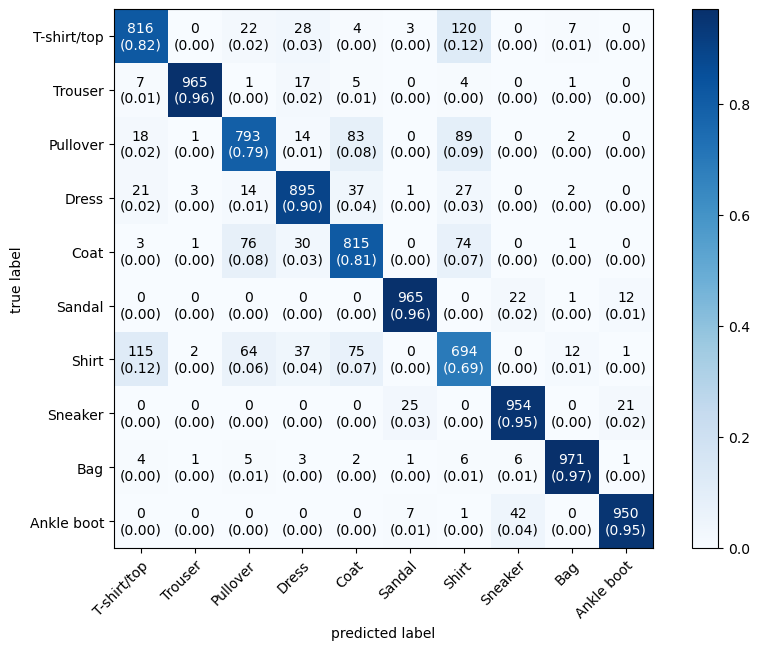

In [ ]:
(
    acc_uncertainty_sampling,
    precision_result_uncertainty_sampling,
    recall_result_uncertainty_sampling,
    f1_result_uncertainty_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "uncertainty_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0269  6.0364
      2        0.0205  6.0360
      3        0.0095  5.9956
      4        0.0146  5.9987
      5        0.0087  5.9945
      6        0.0055  6.0063
      7        0.0163  5.9802
      8        0.0183  5.9951
      9        0.0122  6.0188
     10        0.0205  6.0183
Starting Active Learning with margin_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0208  6.0118
      2        0.0135  6.0222
      3        0.0067  5.9905
      4        0.0059  5.9892
      5        0.0042  6.0097
      6        0.0100  6.0106
      7        0.0127  5.9654
      8        0.0386  6.0849
      9        0.0316  5.9733
     10        0.0303  6.0061
Accuracy after query 1: 0.9050

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0150  6.0052
     

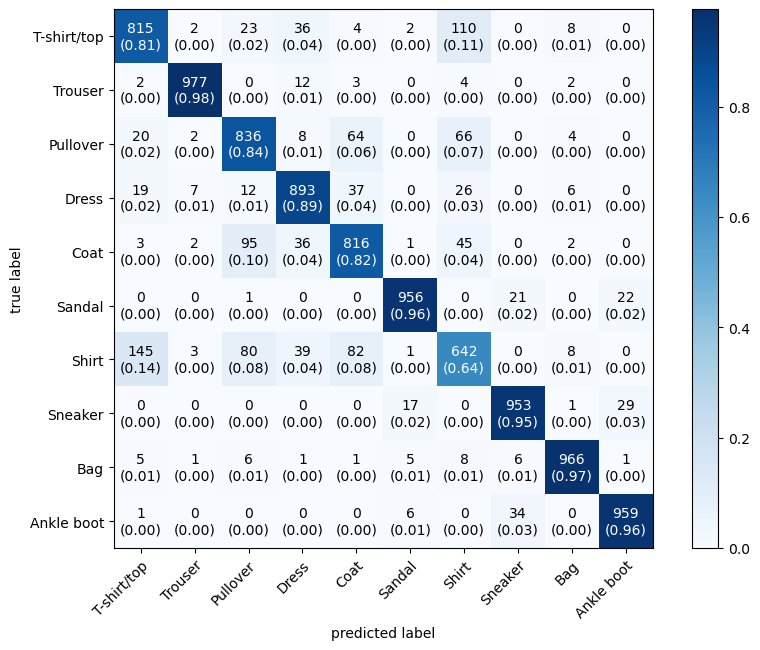

In [ ]:
(
    acc_margin_sampling,
    precision_result_margin_sampling,
    recall_result_margin_sampling,
    f1_result_margin_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "margin_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0133  6.0786
      2        0.0180  6.0448
      3        0.0153  5.9949
      4        0.0121  5.9846
      5        0.0026  6.0136
      6        0.0002  6.0206
      7        0.0001  6.0187
      8        0.0000  6.0033
      9        0.0000  6.0176
     10        0.0000  6.0036
Starting Active Learning with entropy_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0081  6.0613
      2        0.0132  6.1068
      3        0.0294  6.0257
      4        0.0121  6.0197
      5        0.0063  5.9925
      6        0.0007  6.0008
      7        0.0001  6.0213
      8        0.0000  6.0167
      9        0.0000  6.0338
     10        0.0000  6.1054
Accuracy after query 1: 0.9094

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0111  6.0290
    

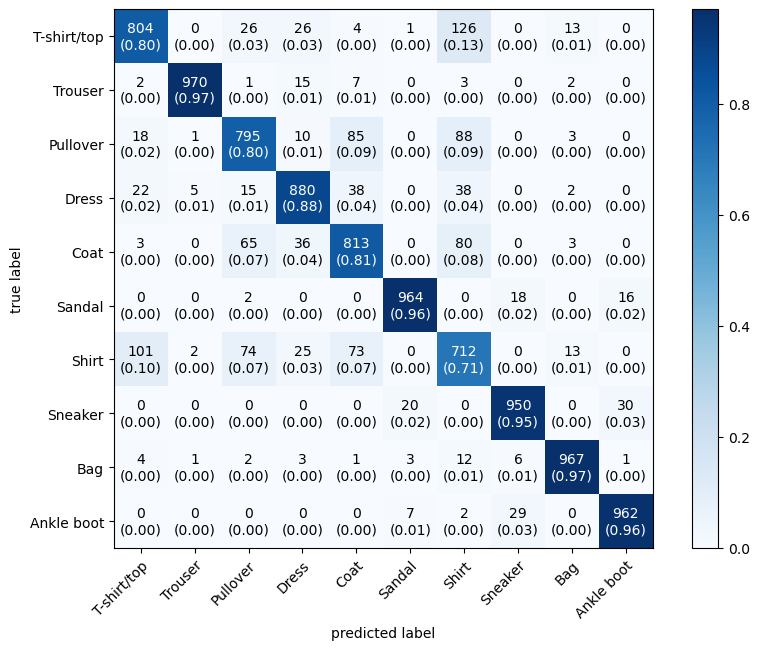

In [ ]:
(
    acc_entropy_sampling,
    precision_result_entropy_sampling,
    recall_result_entropy_sampling,
    f1_result_entropy_sampling,
) = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "entropy_sampling",
    trained_model,
    10,
    FashionMNIST_class_names,
)

# Plot All Metrics


# Accuracy


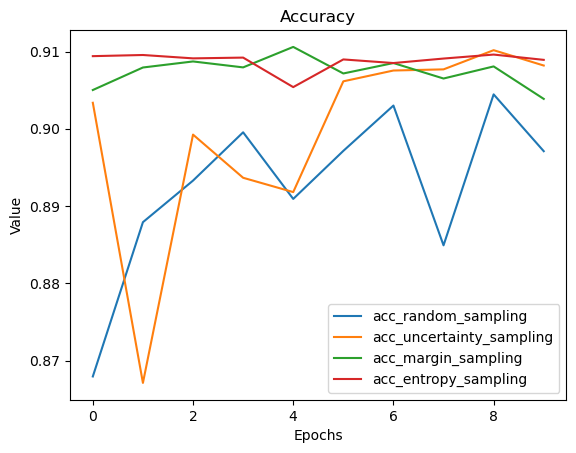

acc_random_sampling: 0.8970995165860977
acc_uncertainty_sampling: 0.908184697449575
acc_margin_sampling: 0.9038673112185365
acc_entropy_sampling: 0.9089181530255043


In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_random_sampling, label="acc_random_sampling")
plt.plot(acc_uncertainty_sampling, label="acc_uncertainty_sampling")
plt.plot(acc_margin_sampling, label="acc_margin_sampling")
plt.plot(acc_entropy_sampling, label="acc_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/acc_base_model_after_al.png")
plt.show()

print(f"acc_random_sampling: {acc_random_sampling[-1]}")
print(f"acc_uncertainty_sampling: {acc_uncertainty_sampling[-1]}")
print(f"acc_margin_sampling: {acc_margin_sampling[-1]}")
print(f"acc_entropy_sampling: {acc_entropy_sampling[-1]}")

# Precision


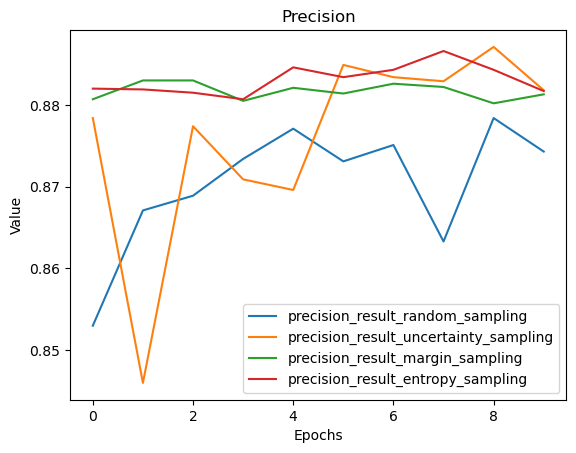

precision_result_random_sampling: 0.8743000030517578
precision_result_uncertainty_sampling: 0.8817999958992004
precision_result_margin_sampling: 0.8812999725341797
precision_result_entropy_sampling: 0.8816999793052673


In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(precision_result_random_sampling, label="precision_result_random_sampling")
plt.plot(
    precision_result_uncertainty_sampling, label="precision_result_uncertainty_sampling"
)
plt.plot(precision_result_margin_sampling, label="precision_result_margin_sampling")
plt.plot(precision_result_entropy_sampling, label="precision_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/prec_base_model_after_al.png")
plt.show()

print(f"precision_result_random_sampling: {precision_result_random_sampling[-1]}")
print(
    f"precision_result_uncertainty_sampling: {precision_result_uncertainty_sampling[-1]}"
)
print(f"precision_result_margin_sampling: {precision_result_margin_sampling[-1]}")
print(f"precision_result_entropy_sampling: {precision_result_entropy_sampling[-1]}")

# Recall


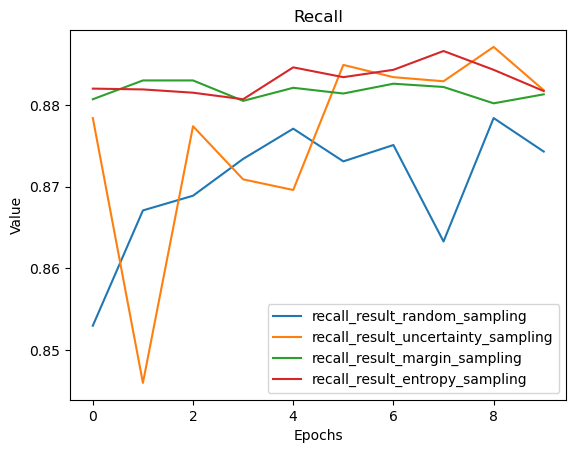

recall_result_random_sampling: 0.8743000030517578
recall_result_uncertainty_sampling: 0.8817999958992004
recall_result_margin_sampling: 0.8812999725341797
recall_result_entropy_sampling: 0.8816999793052673


In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(recall_result_random_sampling, label="recall_result_random_sampling")
plt.plot(recall_result_uncertainty_sampling, label="recall_result_uncertainty_sampling")
plt.plot(recall_result_margin_sampling, label="recall_result_margin_sampling")
plt.plot(recall_result_entropy_sampling, label="recall_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/recall_base_model_after_al.png")
plt.show()

print(f"recall_result_random_sampling: {recall_result_random_sampling[-1]}")
print(f"recall_result_uncertainty_sampling: {recall_result_uncertainty_sampling[-1]}")
print(f"recall_result_margin_sampling: {recall_result_margin_sampling[-1]}")
print(f"recall_result_entropy_sampling: {recall_result_entropy_sampling[-1]}")

# F1 Score


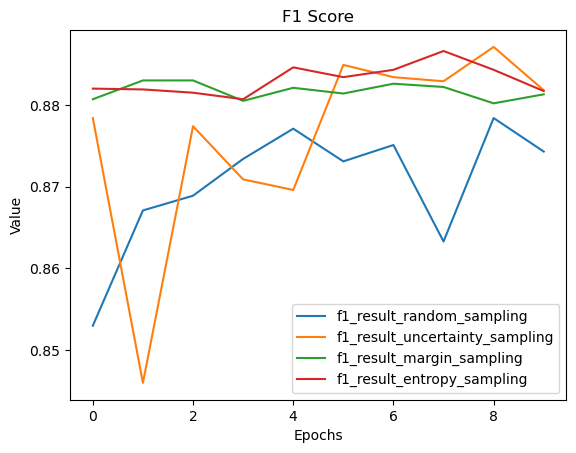

f1_result_random_sampling: 0.8743000030517578
f1_result_uncertainty_sampling: 0.8817999958992004
f1_result_margin_sampling: 0.8812999725341797
f1_result_entropy_sampling: 0.8816999793052673


In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(f1_result_random_sampling, label="f1_result_random_sampling")
plt.plot(f1_result_uncertainty_sampling, label="f1_result_uncertainty_sampling")
plt.plot(f1_result_margin_sampling, label="f1_result_margin_sampling")
plt.plot(f1_result_entropy_sampling, label="f1_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
# Display the plot
plt.legend()
plt.savefig("reports_FashionMNIST/f1_base_model_after_al.png")
plt.show()

print(f"f1_result_random_sampling: {f1_result_random_sampling[-1]}")
print(f"f1_result_uncertainty_sampling: {f1_result_uncertainty_sampling[-1]}")
print(f"f1_result_margin_sampling: {f1_result_margin_sampling[-1]}")
print(f"f1_result_entropy_sampling: {f1_result_entropy_sampling[-1]}")